In [1]:
# default_exp modeling.single_frame_model

In [2]:
#export
from dfdc.modeling.dataset_utils import * 
from fastai.vision import *

In [3]:
data_path = Path("/home/ubuntu/data/dfdc"); data_path.ls()

[PosixPath('/home/ubuntu/data/dfdc/dfdc_face_detections'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_cropped_faces'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_training_csv'),
 PosixPath('/home/ubuntu/data/dfdc/cookies.txt'),
 PosixPath('/home/ubuntu/data/dfdc/dfdc_train')]

In [4]:
cropped_path = data_path/'dfdc_cropped_faces'; print(cropped_path)

/home/ubuntu/data/dfdc/dfdc_cropped_faces


In [5]:
training_csv_path = data_path/'dfdc_training_csv'; print(training_csv_path)

/home/ubuntu/data/dfdc/dfdc_training_csv


### Train-Valid-Test DataFrames

In [6]:
train_parts = list(range(40))
valid_parts = list(range(40,45))
test_parts = list(range(45,50))

In [7]:
len(train_parts), len(test_parts), len(test_parts)

(40, 5, 5)

In [8]:
def read_train_csv(fname):
    df = pd.read_csv(fname, usecols=['fname', 'label', 'original', 'source', 'face_crop_fnames'])
    df['face_crop_fnames'] = df['face_crop_fnames'].apply(eval)
    return df

In [9]:
train_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv') for part_no in train_parts]
valid_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv' )for part_no in valid_parts]
test_dfs = [read_train_csv(training_csv_path/f'part_{part_no}_training.csv') for part_no in test_parts]

In [10]:
train_df = pd.concat(train_dfs).reset_index(drop=True)
valid_df = pd.concat(valid_dfs).reset_index(drop=True)
test_df = pd.concat(test_dfs).reset_index(drop=True)

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((92724, 5), (12111, 5), (12367, 5))

In [12]:
len(train_df.fname.unique()), len(valid_df.fname.unique()), len(test_df.fname.unique())

(92724, 12111, 12367)

In [13]:
train_df.head(4)

fname label        original          source  \
0  owxbbpjpch.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
1  bpguesjrfa.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
2  skewcclbhg.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
3  ybdtkypwez.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   

                                    face_crop_fnames  
0  [dfdc_train_part_0/owxbbpjpch/frame_1_30.jpg, ...  
1  [dfdc_train_part_0/bpguesjrfa/frame_1_30.jpg, ...  
2  [dfdc_train_part_0/skewcclbhg/frame_1_30.jpg, ...  
3  [dfdc_train_part_0/ybdtkypwez/frame_1_30.jpg, ...

In [14]:
def flatten_df(df):
    flat_res = []
    for _, row in df.iterrows():
        fname = row['fname']
        for crop_fname in row['face_crop_fnames']:
            flat_res.append({"fname":fname, "crop_fname":crop_fname, "label":row['label']})
    df = pd.DataFrame(flat_res)
    df.label = df.label.map({"FAKE":1, "REAL":0})
    return df

In [15]:
def create_source2fakes(df):
    source2fakes = defaultdict(list)
    for _, row in df.iterrows():
        if row['source'] != row['fname']:
            source2fakes[row['source']].append(row['fname'])
    return source2fakes

In [16]:
# 50:50 real-fake validation to mimic public test
source2fakes = create_source2fakes(valid_df)

In [17]:
class temporary_seed:
    def __init__(self, seed):
        self.seed = seed
        self.backup = None

    def __enter__(self):
        self.backup = np.random.randint(2**32-1, dtype=np.uint32)
        np.random.seed(self.seed)

    def __exit__(self, *_):
        np.random.seed(self.backup)

In [18]:
with temporary_seed(42):
    sourceslist = list(source2fakes.keys())
    fakeslist = list(np.random.choice(v) for k,v in source2fakes.items())
    subfnames = np.concatenate([sourceslist, fakeslist])
    balanced_valid_df = valid_df[valid_df.fname.isin(subfnames)].reset_index(drop=True)

In [19]:
balanced_valid_df.head(4)

fname label        original          source  \
0  vpkqjedfnn.mp4  FAKE  tkygmnaifp.mp4  tkygmnaifp.mp4   
1  tkygmnaifp.mp4  REAL             NaN  tkygmnaifp.mp4   
2  qyehiscxbr.mp4  REAL             NaN  qyehiscxbr.mp4   
3  ckhiqguxzt.mp4  FAKE  qyehiscxbr.mp4  qyehiscxbr.mp4   

                                    face_crop_fnames  
0  [dfdc_train_part_40/vpkqjedfnn/frame_1_30.jpg,...  
1  [dfdc_train_part_40/tkygmnaifp/frame_1_30.jpg,...  
2  [dfdc_train_part_40/qyehiscxbr/frame_1_30.jpg,...  
3  [dfdc_train_part_40/ckhiqguxzt/frame_1_30.jpg,...

### merge train and test

In [20]:
train_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [21]:
train_df

fname label        original          source  \
0       owxbbpjpch.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
1       bpguesjrfa.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
2       skewcclbhg.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
3       ybdtkypwez.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
4       qwvxbksoeo.mp4  FAKE  wynotylpnm.mp4  wynotylpnm.mp4   
...                ...   ...             ...             ...   
105086  fgmbxfqoze.mp4  REAL             NaN  fgmbxfqoze.mp4   
105087  kudvvlgiff.mp4  REAL             NaN  kudvvlgiff.mp4   
105088  djjdcnhlma.mp4  FAKE  kudvvlgiff.mp4  kudvvlgiff.mp4   
105089  ozjvlnehul.mp4  FAKE  cywebjaezn.mp4  cywebjaezn.mp4   
105090  cywebjaezn.mp4  REAL             NaN  cywebjaezn.mp4   

                                         face_crop_fnames  
0       [dfdc_train_part_0/owxbbpjpch/frame_1_30.jpg, ...  
1       [dfdc_train_part_0/bpguesjrfa/frame_1_30.jpg, ...  
2       [dfdc_train_part_0/skewcclbhg/frame_1_30.jpg, ...  
3       [dfdc_train_part_0/ybdtkypwez/frame_1_30.jpg, ...  
4       [dfdc_train_part_0/qwvxbksoeo/frame_1_30.jpg, ...  
...                                                   ...  
105086  [dfdc_train_part_49/fgmbxfqoze/frame_1_30.jpg,...  
105087  [dfdc_train_part_49/kudvvlgiff/frame_1_30.jpg,...  
105088  [dfdc_train_part_49/djjdcnhlma/frame_1_30.jpg,...  
105089  [dfdc_train_part_49/ozjvlnehul/frame_2_30.jpg,...  
105090  [dfdc_train_part_49/cywebjaezn/frame_2_30.jpg,...  

[105091 rows x 5 columns]

### Transforms

In [22]:
from fastai.vision import transform 

In [23]:
def crappify(pilimg):
    pilimg = pilimg.resize((64,64))
    pilimg = pilimg.resize((224,224))
    return pilimg

In [24]:
def rand_pair_merge(crop_fname, label, face_crop_fnames, labels):
    "crop_fname to merge with a random face with same label"
    # pick random crop with same label
    rand_pair_idx = np.random.choice(np.where(labels == label)[0])
    rand_pair_crop_fname = np.random.choice(face_crop_fnames[rand_pair_idx])
    
    # read both crops
    pilimg1 = read_pilimg(cropped_path/crop_fname)
    pilimg2 = read_pilimg(cropped_path/rand_pair_crop_fname)
    
    # merge both with 50:50
    if np.random.uniform() < 0.5:
        merged_pilimg = PIL.Image.fromarray(np.hstack([np.asarray(pilimg1)[:,:112,:],
                                                   np.asarray(pilimg2)[:,112:,:]]))
    else:
        merged_pilimg = PIL.Image.fromarray(np.hstack([np.asarray(pilimg2)[:,:112,:],
                                                   np.asarray(pilimg1)[:,112:,:]]))
        
    return merged_pilimg

In [25]:
def get_tfms_dict(crappify_thresh=0.25, 
                  fliplr_thresh=0.25,
                  brightness_thresh=0.25, 
                  zoom_thresh=0.25, 
                  rand_merge_thresh=0.5):
    "crappify to low res, flip left-right, change brightness"
    # crappify 
    crappify_p = np.random.uniform(); do_crappify = crappify_p < crappify_thresh
    # fliplr 
    fliplr_p = np.random.uniform(); do_fliplr = fliplr_p < fliplr_thresh
    # change brightness 
    brightness_p = np.random.uniform(); do_brightness = brightness_p < brightness_thresh
    # zoom
    zoom_p = np.random.uniform(); do_zoom = zoom_p < zoom_thresh
    # rand_merge
    rand_merge_p = np.random.uniform(); do_rand_merge = rand_merge_p < rand_merge_thresh
    
    
    if do_brightness: brightness_change = np.random.uniform(0.2,0.8)
    else: brightness_change = None
    if do_zoom: zoom_scale = np.random.uniform(1.15,1.35)
    else: zoom_scale = None
        
    tfms_dict = {"crappify": do_crappify, 
                 "fliplr": do_fliplr, 
                 "brightness": (do_brightness, brightness_change),
                 "zoom": (do_zoom, zoom_scale), 
                 "rand_merge": do_rand_merge}
    return tfms_dict

In [26]:
tfms_dict = get_tfms_dict(1,1,1,1,1); tfms_dict

{'crappify': True,
 'fliplr': True,
 'brightness': (True, 0.47227554450401343),
 'zoom': (True, 1.24625368419492),
 'rand_merge': True}

In [27]:
face_crop_fnames = train_df['face_crop_fnames'].values
labels = train_df['label'].map({"REAL":0, "FAKE":1}).values

In [28]:
rand_fname_idx = np.random.choice(range(len(face_crop_fnames)))
crop_fname = face_crop_fnames[rand_fname_idx][0]
label = labels[rand_fname_idx]; label

1

In [29]:
# # transform
# if tfms_dict['rand_merge']: pilimg = rand_pair_merge(crop_fname, label, face_crop_fnames, labels)
# else: pilimg = read_pilimg(crop_fname)
# if tfms_dict['crappify']: pilimg = crappify(pilimg)
# img = Image(pil2tensor(pilimg, np.float32).div(255))
# if tfms_dict['fliplr']: img = flip_lr(img) 
# if tfms_dict['brightness'][0]: img = brightness(img, tfms_dict['brightness'][1])
# if tfms_dict['zoom'][0]: img = zoom(img, tfms_dict['zoom'][1])
# img

In [30]:
get_tfms_dict(0.2, 0.2, 0.2, 0.2, 0.3)

{'crappify': False,
 'fliplr': False,
 'brightness': (False, None),
 'zoom': (False, None),
 'rand_merge': False}

### Single Frame 1 Fake Batch Sampler

- Permutate original videos
- Pick a random fake for each original video
- Pick same random single frame for both original video and selected fake 
- Original and it's fake should be in same batch - Consistency Loss for focusing on alteration areas

#### Single Real Fake Sampler

In [31]:
class SingleFrameRealFakeSampler(Sampler):
    "Sample single random fake for each source with same single crop frame"
    def __init__(self, train_df):
        
        self.train_df = train_df
        self.unique_originals = np.unique((self.train_df.original).dropna())
        # get fname indexes for sampling
        self.fname2idx = {k:v for v,k in enumerate(self.train_df['fname'])} 
        # get source:fakes mapping 
        self.source2fakes = create_source2fakes(train_df)        
        for k,v in self.source2fakes.items(): assert len(v) > 0
        # convert face crop fnames to array
        self.face_crop_fnames = self.train_df['face_crop_fnames'].values
        
        
    def __iter__(self):
        # shuffle original videos
        unique_originals = np.random.permutation(self.unique_originals)
        
        # collect indexes for source and fake
        all_idxs = []
        for source in unique_originals: 
            fake = np.random.choice(self.source2fakes[source])
            source_fname_idx = self.fname2idx[source]
            fake_fname_idx = self.fname2idx[fake]
            
            # pick a random frame for real and fake
            num_frames = len(self.face_crop_fnames[source_fname_idx])
            rand_crop_idx = np.random.choice(range(num_frames))
            
            # real video, fake video, random frame
            all_idxs.append((source_fname_idx, fake_fname_idx, rand_crop_idx))
        
        return iter(all_idxs)
    
    def __len__(self):
        return len(self.unique_originals)*2

#### BatchSampler

In [32]:
class SingleFrameRealFakeBatchSampler(Sampler):
    "Batch real and fake pairs from sampler with same tfms"
    def __init__(self, sampler, batch_size, drop_last, tfms=True):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.tfms = tfms

    def __iter__(self):
        batch = []
        for real_idx, fake_idx, crop_idx in self.sampler:
            # get tfms dict for augmentation
            if self.tfms: tfms_dict = get_tfms_dict(0.2, 0.2, 0.2, 0.2, 0.4)
            else: tfms_dict = None
            batch.append((real_idx, crop_idx, tfms_dict))
            batch.append((fake_idx, crop_idx, tfms_dict))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

#### Dataset

In [33]:
def read_pilimg(crop_fname, cropped_path=cropped_path):
    return (PIL.Image.open(cropped_path/crop_fname)
                  .convert('RGB')
                  .resize((224,224)))

class SingleFrameRealFakeDataset(Dataset):
    def __init__(self, cropped_path, df, sampler):
        self.sampler = sampler
        self.cropped_path = cropped_path
        self.df = df
        self.face_crop_fnames = df['face_crop_fnames'].values
        self.labels = df['label'].map({"REAL":0, "FAKE":1}).values
        
    def __getitem__(self, idxs:Tuple):
        fname_idx, crop_idx, tfms_dict = idxs
        
        # get label
        label = self.labels[fname_idx]
        
        # read image with or w/o transform
        crop_fname = self.face_crop_fnames[fname_idx][crop_idx]
        if tfms_dict is not None:
            if tfms_dict['rand_merge']: 
                pilimg = rand_pair_merge(crop_fname, label, self.face_crop_fnames, self.labels)
            else: 
                pilimg = read_pilimg(crop_fname)
            if tfms_dict['crappify']: pilimg = crappify(pilimg)
            img = Image(pil2tensor(pilimg, np.float32).div(255))
            if tfms_dict['fliplr']: img = flip_lr(img) 
            if tfms_dict['brightness'][0]: img = brightness(img, tfms_dict['brightness'][1])
            if tfms_dict['zoom'][0]: img = zoom(img, tfms_dict['zoom'][1])
            img = img.data
        else:
            pilimg = read_pilimg(crop_fname)
            img = pil2tensor(pilimg, np.float32).div(255)
        
        
        # normalize
        img = normalize(img, *[tensor(o) for o in imagenet_stats])
        return img, label
    
    def __len__(self): return len(self.sampler)

#### Validation Samplers

In [34]:
class SingleFrameValidSampler(Sampler):
    "sample all frames for each given video in df"
    def __init__(self, valid_df):
        valid_idxs = []
        valid_face_crop_fnames = valid_df.face_crop_fnames.values
        for i, l in enumerate(valid_face_crop_fnames):
            for j in range(len(l)):
                valid_idxs.append((i,j,None))
        self.valid_idxs = valid_idxs
        
    def __iter__(self): return iter(self.valid_idxs)
    def __len__(self): return len(self.valid_idxs)

In [35]:
class SingleFrameValidRandomSampler(Sampler):
    "sample 1 random for each given video in df"
    def __init__(self, valid_df):
        valid_idxs = []
        valid_face_crop_fnames = valid_df.face_crop_fnames.values
        for i, l in enumerate(valid_face_crop_fnames):
            with temporary_seed(42):
                j = np.random.choice(range(len(l)))
            valid_idxs.append((i,j,None))
        self.valid_idxs = valid_idxs
        
    def __iter__(self): return iter(self.valid_idxs)
    def __len__(self): return len(self.valid_idxs)

### Single Frame All Fakes Batch Sampler

- Permutate original videos
- Pick all fakes for each original video
- Pick same random single frame for both original video and fakes
- Original and fakes should be in same batch - Consistency Loss for focusing on alteration areas

1 Real All Fakes Sampler

In [36]:
class SingleFrameRealAllFakesSampler(Sampler):
    "Sample all fakes for a given original video"
    def __init__(self, train_df):
        
        self.train_df = train_df
        self.unique_originals = np.unique((self.train_df.original).dropna())
        
        # get fname indexes for sampling
        self.fname2idx = {k:v for v,k in enumerate(self.train_df['fname'])} 
        
        # get source 2 fake mapping 
        self.source2fakes = defaultdict(list)
        for _, row in train_df.iterrows():
            if row['source'] != row['fname']:
                self.source2fakes[row['source']].append(row['fname'])
        
        # each original should have at least 1 fake
        for k,v in self.source2fakes.items(): assert len(v) > 0
        
        # convert face crop fnames to array
        self.face_crop_fnames = self.train_df['face_crop_fnames'].values
        
        
    def __iter__(self):
        # shuffle original videos
        unique_originals = np.random.permutation(self.unique_originals)
        
        # collect indexes for source and fake
        all_idxs = []
        for source in unique_originals: 
            fakes = self.source2fakes[source]
            source_fname_idx = self.fname2idx[source]
            
            # pick a random frame for real and fakes
            rand_crop_idx = np.random.choice(range(len(self.face_crop_fnames[source_fname_idx])))
            
            # append real video, fake video, random frame
            fake_fname_idxs = [self.fname2idx[fake] for fake in fakes]
            all_idxs.append((source_fname_idx, fake_fname_idxs, rand_crop_idx))
                
        return iter(all_idxs)
    
    def __len__(self):
        return len(self.train_df)

1 Real All Fakes BatchSampler

In [37]:
class SingleFrameRealAllFakesBatchSampler(Sampler):
    "Batch all fakes for a given original video"
    def __init__(self, sampler, batch_size, drop_last=False, tfms=True):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.tfms = tfms

    def __iter__(self):
        batch = []
        for real_idx, fake_idxs, crop_idx in self.sampler:
            # get tfms dict for augmentation
            if self.tfms: tfms_dict = get_tfms_dict(0.25, 0.25, 0.25, 0.35)
            else: tfms_dict = None
            batch.append((real_idx, crop_idx, tfms_dict))
            for fake_idx in fake_idxs:
                batch.append((fake_idx, crop_idx, tfms_dict))
            if len(batch) > self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch

    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size

### Create Train Dataloader

In [38]:
bs = 32

In [39]:
_mean, _std = tensor(imagenet_stats[0]), tensor(imagenet_stats[1])

In [40]:
train_sampler = SingleFrameRealFakeSampler(train_df) # 1 real 1 fake
# train_sampler = SingleFrameRealAllFakesSampler(train_df) # 1 real All fakes

In [41]:
batch_sampler = SingleFrameRealFakeBatchSampler(train_sampler, 
                                                batch_size=bs,
                                                drop_last=False, 
                                                tfms=True) # 1 real 1 fake 

# batch_sampler = SingleFrameRealAllFakesBatchSampler(train_sampler, 
#                                                 batch_size=64,
#                                                 drop_last=False, 
#                                                 tfms=True) # 1 real All fakes

train_ds = SingleFrameRealFakeDataset(cropped_path, train_df, train_sampler)
train_dl = DataLoader(train_ds, batch_sampler=batch_sampler, num_workers=defaults.cpus)

In [42]:
xb, yb = next(iter(train_dl))

In [43]:
def denorm_tensor(t): return (t*_std[...,None, None] + _mean[...,None,None])

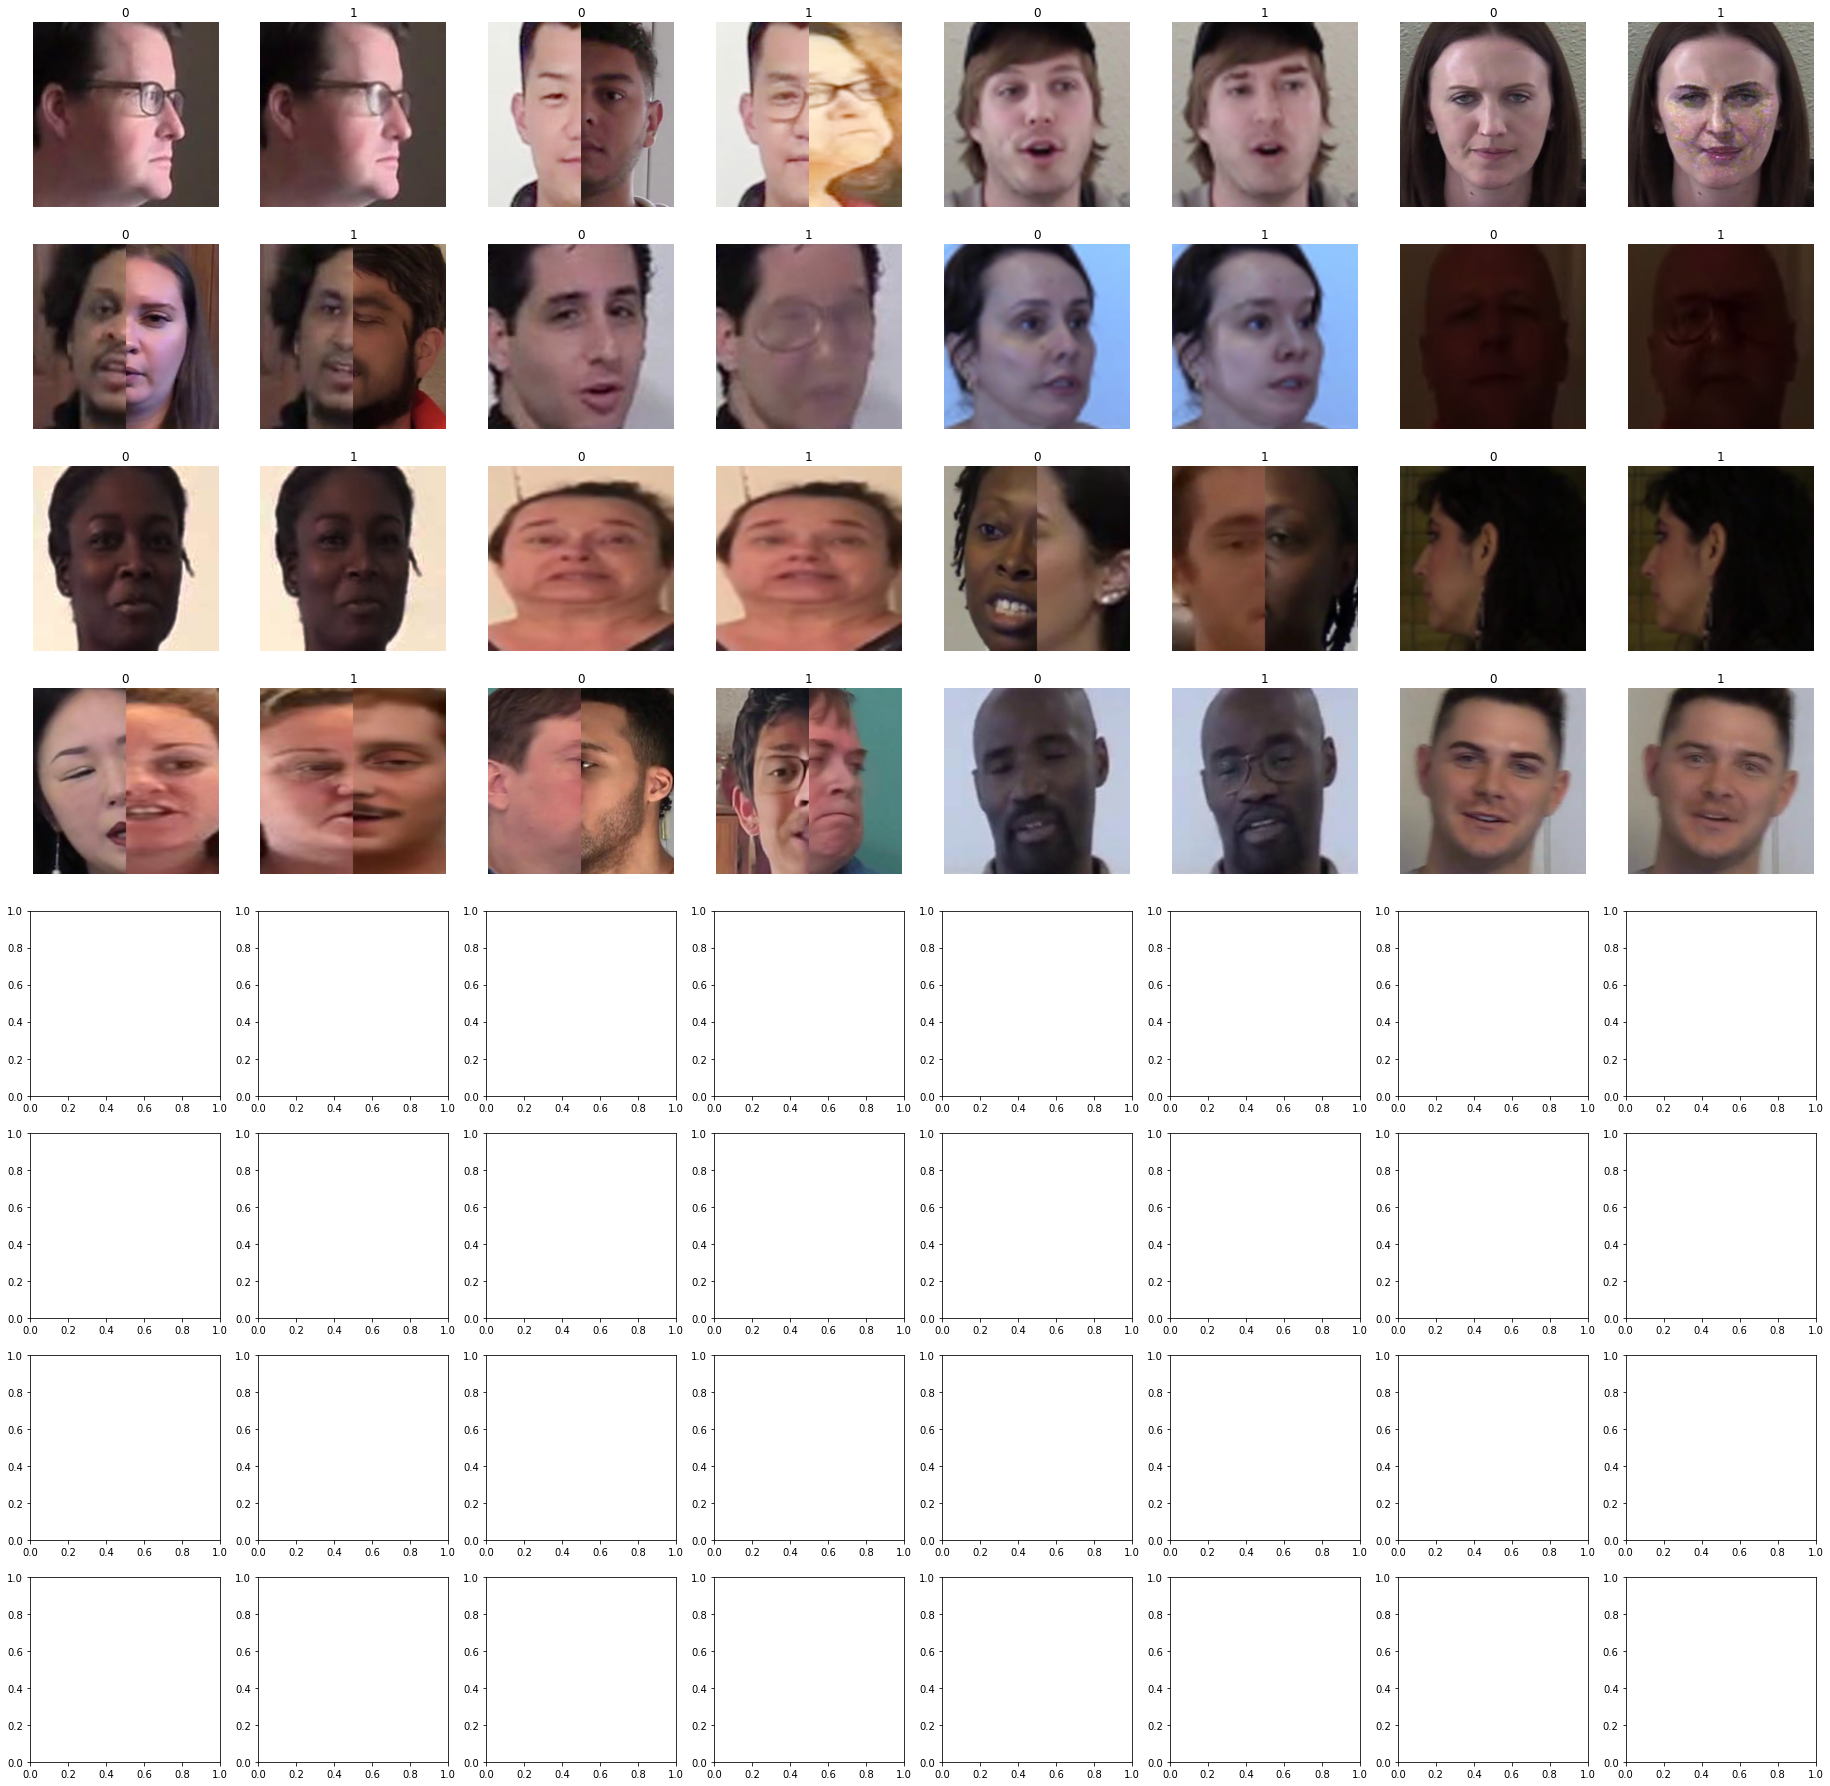

In [44]:
n = 8
axes = subplots(n,n).flatten()
for ax, t, l in zip(axes, xb[:n**2], yb[:n**2]):
    im = Image(denorm_tensor(t))
    im.show(ax=ax, title=l.item())

### Create Valid Dataloader

In [45]:
# sample all frames
valid_sampler = SingleFrameValidSampler(balanced_valid_df)
valid_ds = SingleFrameRealFakeDataset(cropped_path, balanced_valid_df, valid_sampler)
valid_dl = DataLoader(valid_ds, bs*2, sampler=valid_sampler, num_workers=defaults.cpus)

In [46]:
# sample single random frame
valid_random_sampler = SingleFrameValidRandomSampler(balanced_valid_df)
valid_random_ds = SingleFrameRealFakeDataset(cropped_path, balanced_valid_df, valid_random_sampler)
valid_random_dl = DataLoader(valid_random_ds, bs*2, sampler=valid_random_sampler, num_workers=defaults.cpus)

In [47]:
xb, yb = next(iter(valid_dl))

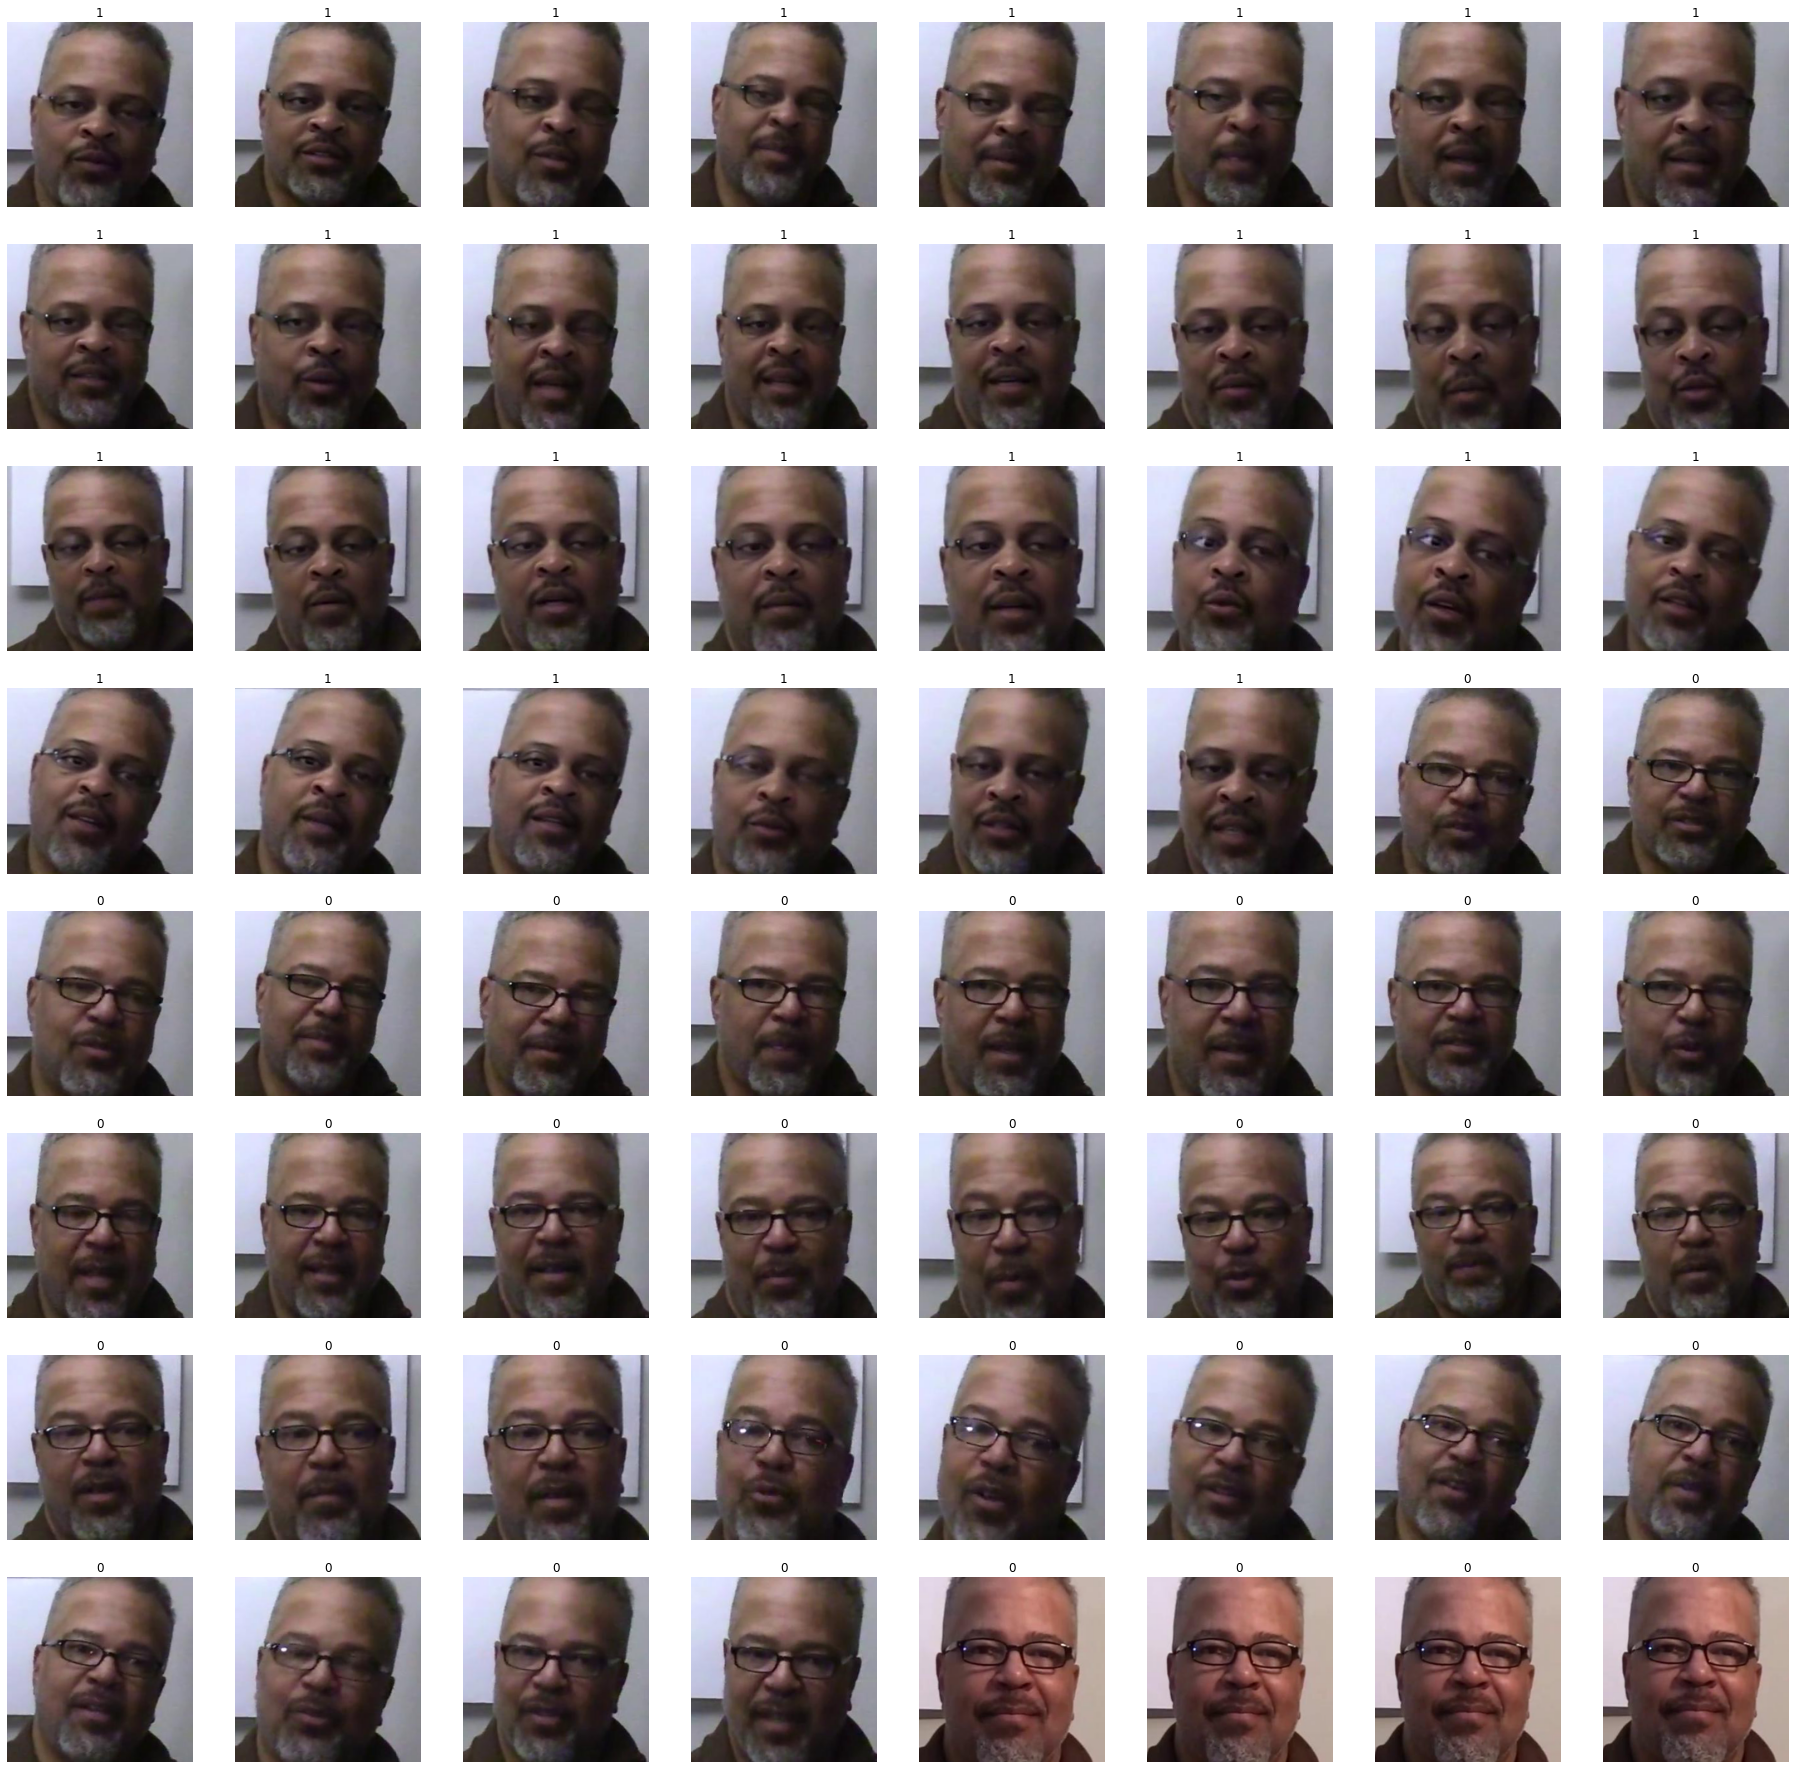

In [48]:
n = 8
axes = subplots(n,n).flatten()
for ax, t, l in zip(axes, xb[:n**2], yb[:n**2]):
    im = Image(denorm_tensor(t))
    im.show(ax=ax, title=l.item())

In [49]:
del xb, yb
gc.collect()

131951

### transfer learning

In [50]:
from fastai.callbacks import *
from fastai.vision.models.cadene_models import *
from fastai.vision.models.efficientnet import *
from fastai.vision.models.xresnet2 import *

In [51]:
class MeanValidLoss(Callback):
    "Stores predictions and targets to perform calculations on epoch end."
    def __init__(self, df):
        self.valid_df = df
        self.valid_flat_df = flatten_df(df)
        self.loss_fn = CrossEntropyFlat()
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = Tensor([]), Tensor([])        

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().float()))
        
    def on_epoch_end(self, last_metrics, **kwargs):
        self.targs = to_np(self.targs.long())
        self.valid_flat_df['preds'] = to_np(self.preds)[:, 1]
        
        mean_preds = self.valid_flat_df.groupby("fname")['preds'].mean().values
        mean_labels = self.valid_flat_df.groupby("fname")['label'].mean().values
        
        mean_preds_torch = torch.stack([1-tensor(mean_preds), tensor(mean_preds)], 1)
        mean_targs_torch = tensor(mean_labels)
        
        res = self.loss_fn(mean_preds_torch, mean_targs_torch)
        return add_metrics(last_metrics, res)

Create learner with random validation

In [52]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        
        ce = F.cross_entropy(inputs, targets, reduction='none')

        pt = torch.exp(F.log_softmax(inputs.data, dim=1))
        pt = pt[:,0]*(1 - targets) + pt[:,1]*(targets) 
        
        focal_loss = self.alpha * (1-pt)**self.gamma * ce

        return focal_loss.mean()

In [53]:
# data = DataBunch(train_dl, valid_random_dl); data.c = 2
data = DataBunch(train_dl, valid_dl); data.c = 2

In [54]:
# # model_fn = models.resnet34
# # model_fn = inceptionresnetv2
# model_fn = xresnet50_2
# learner = cnn_learner(data, model_fn, ps=0.7, pretrained=False)
# learner.to_fp16();
# learner.loss_func = CrossEntropyFlat()

In [62]:
def split_fn_effnet(m): return (m._blocks[20], m._bn1)
model = EfficientNetB7(data)
learner = Learner(data, model)
learner.to_fp16();
learner.loss_func = CrossEntropyFlat()
# learner.loss_func = FocalLoss()
learner.split(split_fn_effnet);
learner.freeze_to(2);

Loaded pretrained weights for efficientnet-b7


In [63]:
metric = MeanValidLoss(balanced_valid_df)
learner.metrics = [metric, accuracy]

In [57]:
# learner.lr_find()
# learner.recorder.plot()

In [64]:
early_stop_cb = EarlyStoppingCallback(learner,
                                      monitor='mean_valid_loss',
                                      mode='min',
                                      patience=10)
save_model_cb = SaveModelCallback(learner,
                                  every='improvement', 
                                  monitor='mean_valid_loss',
                                  name='single_frame_effnetb7_randmerge')

In [65]:
mixup = MixUpCallback(learner)

In [66]:
lr=1e-2

In [ ]:
learner.freeze_to(2)
learner.fit_one_cycle(100, slice(lr), callbacks=[early_stop_cb, save_model_cb])

Better model found at epoch 0 with mean_valid_loss value: 0.774853527545929.
Better model found at epoch 1 with mean_valid_loss value: 0.7562316060066223.
Better model found at epoch 2 with mean_valid_loss value: 0.7258925437927246.
Better model found at epoch 4 with mean_valid_loss value: 0.7097744345664978.
Better model found at epoch 5 with mean_valid_loss value: 0.6804683208465576.
Better model found at epoch 6 with mean_valid_loss value: 0.6662938594818115.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 9 with mean_valid_loss value: 0.5715543627738953.
Better model found at epoch 10 with mean_valid_loss value: 0.5563691854476929.
Better model found at epoch 11 with mean_valid_loss value: 0.5347530841827393.


In [ ]:
learner.freeze_to(1)
learner.fit_one_cycle(100, slice(lr/3), callbacks=[early_stop_cb, save_model_cb, mixup])

Create learner with all validation

In [ ]:
# data = DataBunch(train_dl, valid_dl); data.c = 2
# learner.data = data
# metric = MeanValidLoss(valid_df)
# learner.metrics = [metric]
# learner.to_fp16();

In [ ]:
learner.load("single_frame_effnetb7_randmerge");
learner.to_fp16();
learner.loss_func = FocalLoss()
learner.metrics = [metric, accuracy]

In [ ]:
# early_stop_cb = EarlyStoppingCallback(learner,
#                                       monitor='mean_valid_loss',
#                                       mode='min',
#                                       patience=10)
# save_model_cb = SaveModelCallback(learner, 
#                                   every='improvement',
#                                   monitor='mean_valid_loss',
#                                   name='single_frame_final_effnetb5')

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(25, slice(lr/9), callbacks=[early_stop_cb, save_model_cb, mixup])

In [ ]:
learner.validate()

In [ ]:
learner.save_model_callback.name

### validate

In [55]:
learner.load('single_frame_final_inception');
learner.to_fp32();

In [56]:
learner.data.valid_ds.sampler

In [57]:
preds, targs = learner.get_preds()

In [70]:
valid_flat_df = flatten_df(valid_df)
assert all((valid_flat_df['label']).values == to_np(targs))

In [109]:
preds0 = to_np(preds)[:,0]
preds1 = to_np(preds)[:,1]
targs_np = to_np(targs)

In [142]:
F.binary_cross_entropy(tensor(preds1), targs.float())

tensor(0.2731)

In [93]:
valid_flat_df['preds'] = preds1

In [189]:
mean_df = valid_flat_df.groupby("fname")[['label', 'preds']].mean()

In [190]:
mean_df = mean_df.reset_index()

In [155]:
def create_source2fakes(df):
    source2fakes = defaultdict(list)
    for _, row in df.iterrows():
        if row['source'] != row['fname']:
            source2fakes[row['source']].append(row['fname'])
    return source2fakes

In [156]:
source2fakes = create_source2fakes(valid_df)

In [197]:
sourceslist = list(source2fakes.keys())
fakeslist = list(np.random.choice(v) for k,v in source2fakes.items())
subfnames = np.concatenate([sourceslist, fakeslist])
submean_df = mean_df[mean_df.fname.isin(subfnames)]

In [198]:
mean_preds1 = tensor(submean_df['preds'].values)
mean_targs = tensor(submean_df['label'].values)

In [199]:
F.binary_cross_entropy(tensor(mean_preds1), mean_targs.float())

tensor(0.2577)

### test

In [104]:
test_sampler = SingleFrameValidSampler(test_df)
test_ds = SingleFrameRealFakeDataset(cropped_path, test_df, test_sampler)

In [105]:
test_dl = DeviceDataLoader(DataLoader(test_ds, 128, sampler=test_sampler, num_workers=defaults.cpus),
                           device=defaults.device)
learner.data.valid_dl = test_dl

In [106]:
metric = MeanValidLoss(test_df)
learner.metrics = [metric]

In [109]:
learner.to_fp16();
learner.validate()

[0.2791183, tensor(0.1625)]


### analyze preds

In [110]:
preds, targs = learner.get_preds()

In [126]:
preds.shape, targs.shape

(torch.Size([346373, 2]), torch.Size([346373]))

In [127]:
targs

tensor([1, 1, 1,  ..., 0, 0, 0])

In [128]:
preds

tensor([[3.4002e-05, 9.9997e-01],
        [2.2212e-05, 9.9998e-01],
        [1.8559e-05, 9.9998e-01],
        ...,
        [9.6729e-01, 3.2713e-02],
        [9.9847e-01, 1.5307e-03],
        [9.9938e-01, 6.2268e-04]])

In [129]:
test_flat_df = flatten_df(test_df)

In [130]:
test_flat_df['preds'] = to_np(preds[:,1])

In [131]:
rand_fname = np.random.choice(test_flat_df.fname.unique())
subdf = test_flat_df[test_flat_df.fname == rand_fname].reset_index(drop=True)
subpreds = subdf['preds'].values

In [132]:
subdf['label'].unique(), min(subpreds), max(subpreds), np.mean(subpreds)

(array([1]), 0.005576545, 0.9999962, 0.9667486)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.]),
 array([0.005577, 0.105019, 0.20446 , 0.303902, 0.403344, 0.502786, 0.602228, 0.70167 , 0.801112, 0.900554, 0.999996],
       dtype=float32),
 <a list of 10 Patch objects>)

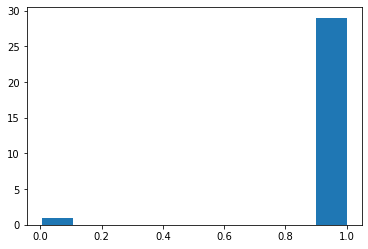

In [133]:
plt.hist(subdf['preds'])

In [134]:
meandf = test_flat_df.groupby("fname").mean()

In [135]:
min(meandf['preds']), max(meandf['preds'])

(4.1724074861804183e-08, 0.9999969005584717)

In [136]:
bestscore = 1
for clipval in np.arange(0.001, 0.2, 0.001):
    mean_labels = meandf['label'].values
    mean_preds = meandf['preds'].values
    mean_preds = np.clip(mean_preds, clipval, 1-clipval)
    score = - np.mean(np.concatenate([mean_labels*np.log(mean_preds), (1-mean_labels)*np.log(1-mean_preds)]))
    if score < bestscore:
        bestscore = score
        bestval = clipval

In [137]:
bestscore, bestval

(0.07985394583093856, 0.006)

### confusion matrix & accuracy

In [138]:
from sklearn.metrics import confusion_matrix

In [139]:
confusion_matrix(meandf['label'].values, (meandf['preds'] > 0.5).values)

array([[1764,  395],
       [ 308, 9900]])

In [140]:
np.mean(meandf['label'].values == (meandf['preds'] > 0.5).values)

0.9431551710196491

### visualize false n/p

In [148]:
min(meandf['preds']), max(meandf['preds'])

(2.00074623535329e-10, 0.9999976754188538)

In [158]:
logloss = -(meandf['label']*np.log(np.clip(meandf['preds'], 0.01, 0.99))
      + (1 - meandf['label'])*np.log(1 - np.clip(meandf['preds'], 0.01, 0.99)))

In [165]:
test_df['preds'] =test_df['fname'].map(meandf['preds'])
test_df['logloss'] = test_df['fname'].map(logloss)

In [169]:
sorted_test_df = test_df.sort_values('logloss', ascending=False).reset_index(drop=True)

In [173]:
sorted_test_df.head(10)

fname label original          source  \
0  eswzqomvye.mp4  REAL      NaN  eswzqomvye.mp4   
1  dwkmwwyvpj.mp4  REAL      NaN  dwkmwwyvpj.mp4   
2  uvzlfuxalu.mp4  REAL      NaN  uvzlfuxalu.mp4   
3  vibhrvveql.mp4  REAL      NaN  vibhrvveql.mp4   
4  xiwpvcxuhr.mp4  REAL      NaN  xiwpvcxuhr.mp4   
5  armthxafvt.mp4  REAL      NaN  armthxafvt.mp4   
6  icjdgqaegf.mp4  REAL      NaN  icjdgqaegf.mp4   
7  hwsgjnslze.mp4  REAL      NaN  hwsgjnslze.mp4   
8  skipjcgjjv.mp4  REAL      NaN  skipjcgjjv.mp4   
9  pxstpntfik.mp4  REAL      NaN  pxstpntfik.mp4   

                                    face_crop_fnames     preds   logloss  
0  [dfdc_train_part_48/eswzqomvye/frame_1_30.jpg,...  0.993195  4.605171  
1  [dfdc_train_part_45/dwkmwwyvpj/frame_1_30.jpg,...  0.999852  4.605171  
2  [dfdc_train_part_45/uvzlfuxalu/frame_1_30.jpg,...  0.999770  4.605171  
3  [dfdc_train_part_45/vibhrvveql/frame_1_30.jpg,...  0.999224  4.605171  
4  [dfdc_train_part_48/xiwpvcxuhr/frame_1_31.jpg,...  0.991617  4.605171  
5  [dfdc_train_part_45/armthxafvt/frame_1_30.jpg,...  0.999875  4.605171  
6  [dfdc_train_part_45/icjdgqaegf/frame_1_30.jpg,...  0.999872  4.605171  
7  [dfdc_train_part_48/hwsgjnslze/frame_1_31.jpg,...  0.996124  4.605171  
8  [dfdc_train_part_45/skipjcgjjv/frame_1_30.jpg,...  0.999810  4.605171  
9  [dfdc_train_part_45/pxstpntfik/frame_1_30.jpg,...  0.999885  4.605171

<BarContainer object of 12367 artists>

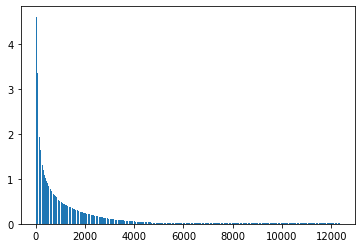

In [254]:
plt.bar(range(len(sorted_test_df['logloss'])), sorted_test_df['logloss'])

In [188]:
rows = iter(sorted_test_df.iterrows())

In [294]:
_, row = next(rows); row

fname                                                  iofnzcsfzb.mp4
label                                                            FAKE
original                                               wsdaezrogo.mp4
source                                                 wsdaezrogo.mp4
face_crop_fnames    [dfdc_train_part_49/iofnzcsfzb/frame_1_30.jpg,...
preds                                                       0.0164949
logloss                                                        4.1047
Name: 47, dtype: object

In [ ]:
n = int(np.ceil(np.sqrt(len(row['face_crop_fnames']))))
for crop_fname, ax in  zip(row['face_crop_fnames'], subplots(n,n).flatten()):
    img = open_image(cropped_path/crop_fname)
    img.show(ax=ax)

### Grad CAM

In [228]:
m = learner.to_fp32().model.eval()

In [ ]:
xb, yb = next(iter(train_dl))

In [229]:
def show_gradcam(m:Module, x:Tensor, y:Tensor, heatmap_thresh = 16, ax=None):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(x[None, ...].cuda())
            preds[0,y].backward()

    acts  = hook_a.stored[0].cpu() #activation maps
    if (acts.shape[-1]*acts.shape[-2]) >= heatmap_thresh:
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = F.relu(((acts*grad_chan[...,None,None])).sum(0))

    xb_im = Image(denorm_tensor(x))
    if ax is None: _,ax = plt.subplots()
    sz = list(xb_im.shape[-2:])
    prob = np.round(to_np(preds.softmax(1)[0,y]), 3)
    xb_im.show(ax, title=f"pred proba: {prob} gt: {y.item()}")
    ax.imshow(mult, alpha=0.4, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')

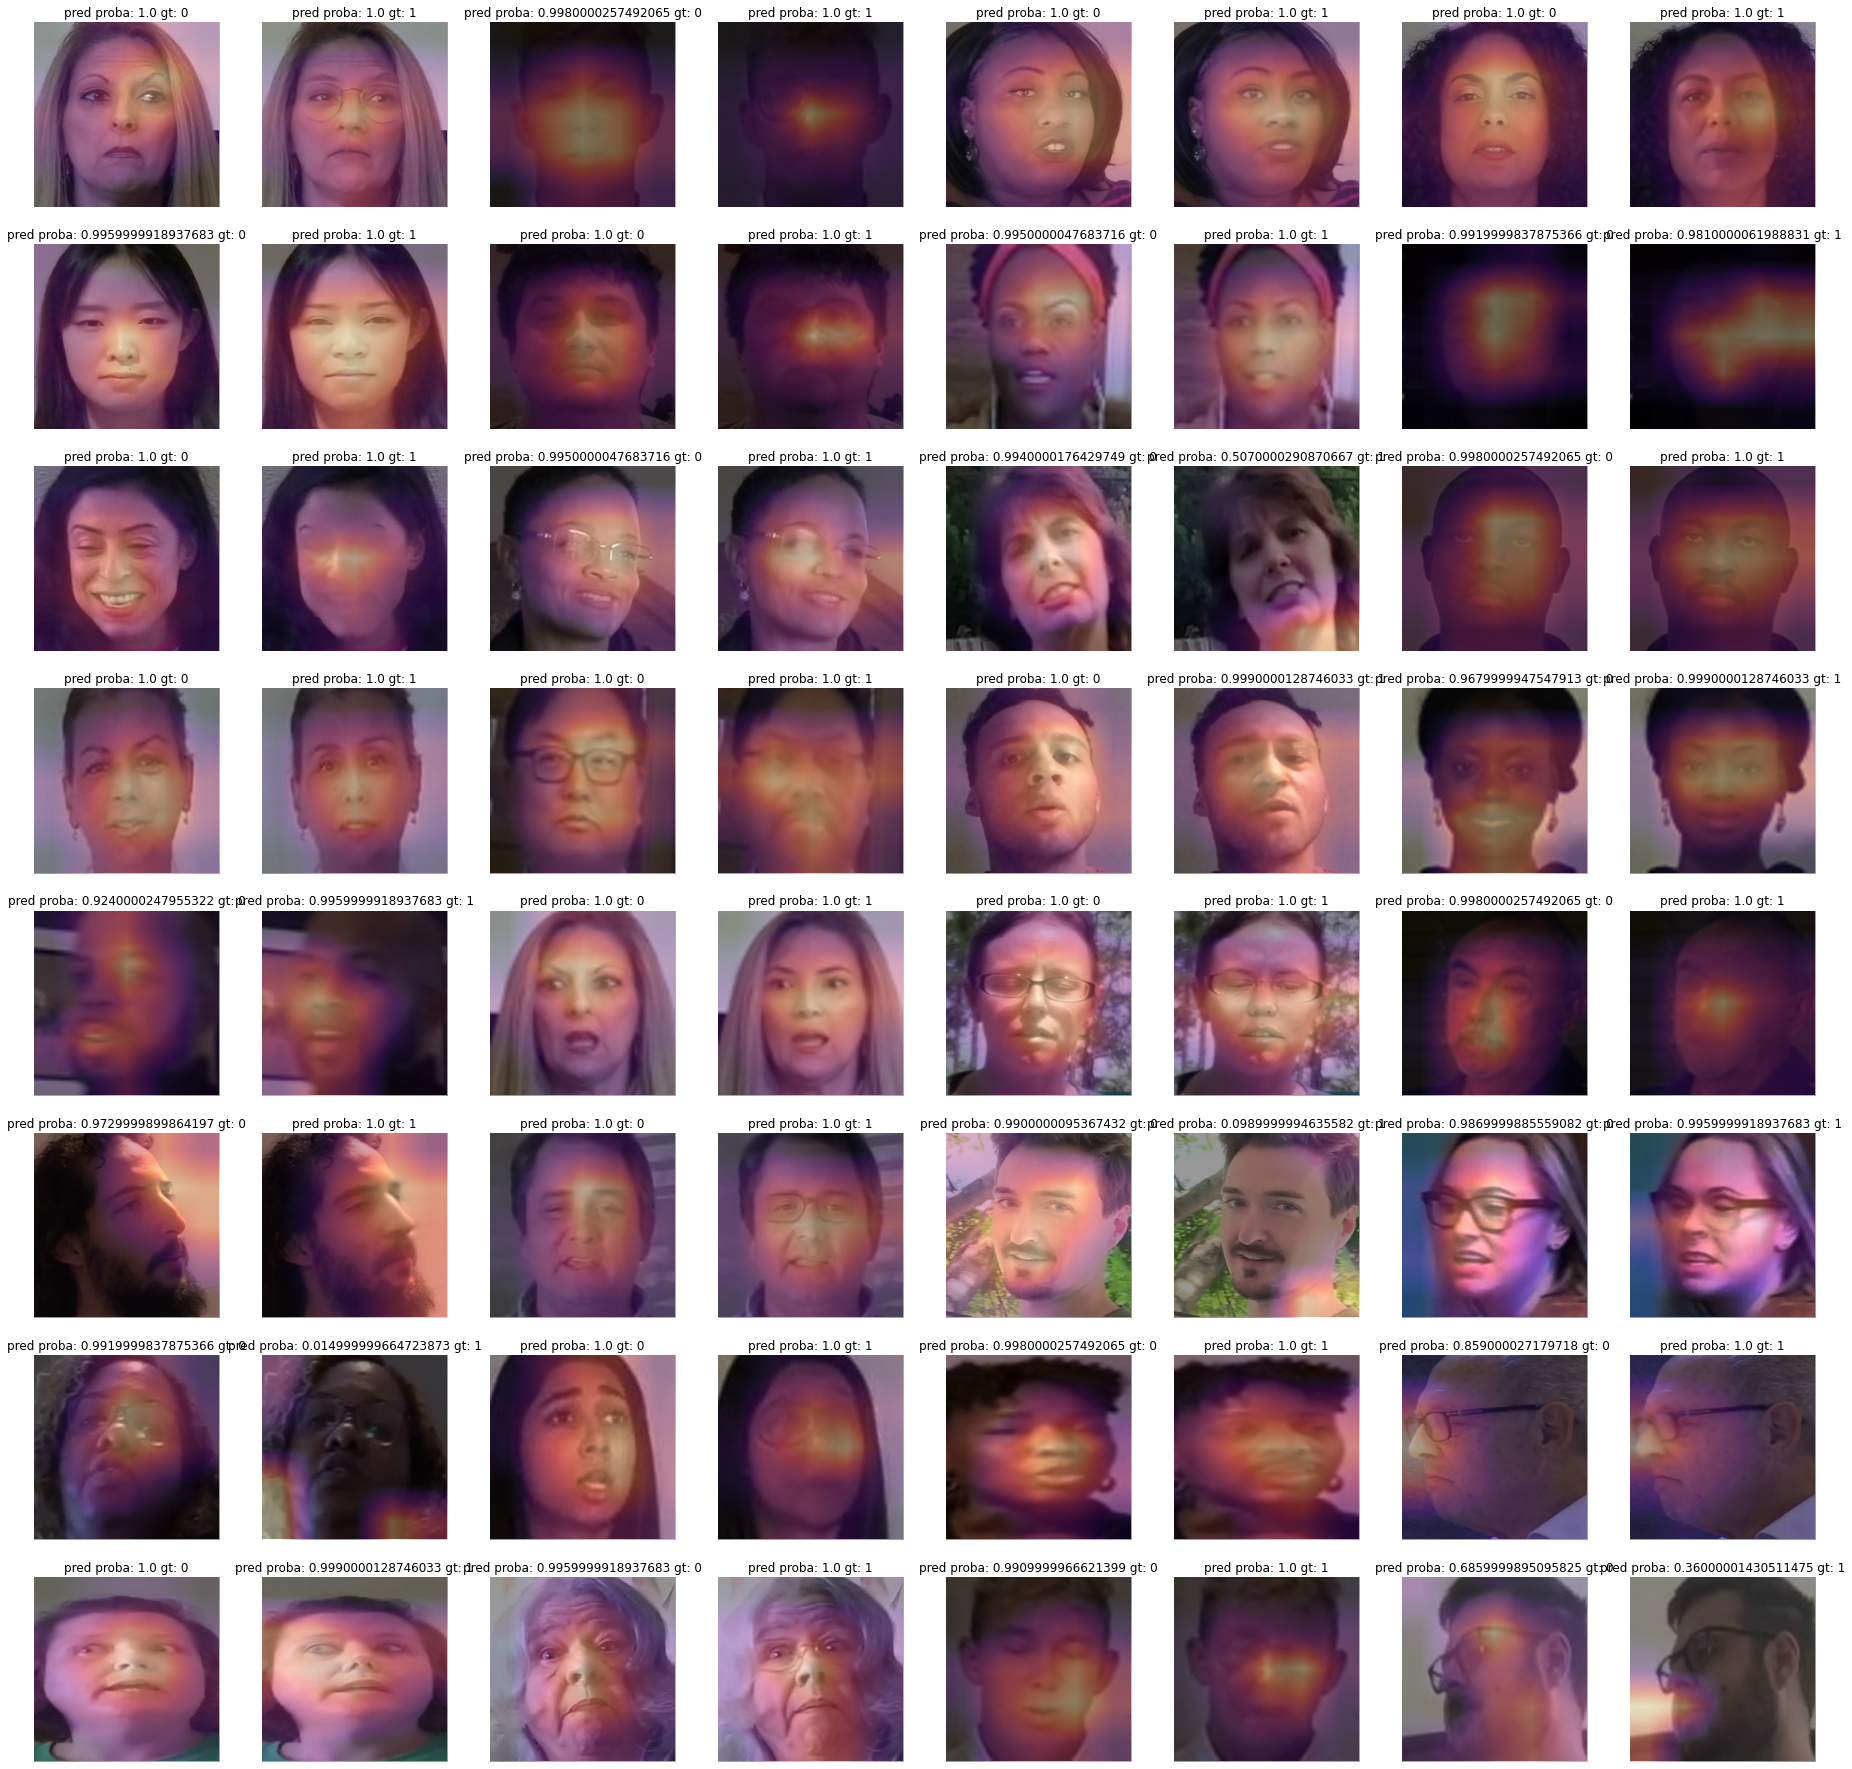

In [230]:
n = 8
axes = subplots(n,n).flatten()
for ax, t, l in zip(axes, xb[:n**2], yb[:n**2]):
    show_gradcam(m,t,l,ax=ax)

### download model

In [79]:
from IPython.display import FileLink
FileLink(learner.data.path/learner.model_dir/'single_frame_effnetb5_randmerge.pth')

/home/ubuntu/git/dfdc/nbs/models/single_frame_effnetb5_randmerge.pth

### export 

In [26]:
from nbdev.export import notebook2script
notebook2script()